# Step #1 Generate Synthetic Time Series Data

Text(0.5, 1.0, 'sine curve data')

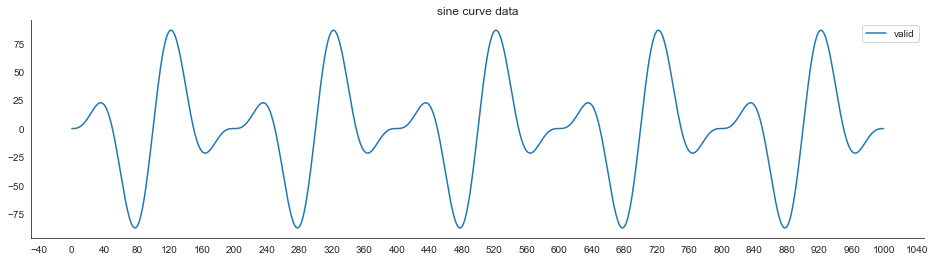

In [103]:
# A tutorial for this file is available at www.relataly.com

import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl 
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import LSTM, Dense
import seaborn as sns
sns.set_style('white', { 'axes.spines.right': False, 'axes.spines.top': False})

# Creating the sample sinus curve dataset
steps = 1000; gradient = 0.002
list_a = []
for i in range(0, steps, 1):
    y = 100 * round(math.sin(math.pi * i * 0.02 + 0.01), 4) * round(math.sin(math.pi * i * 0.005 + 0.01), 4) * round(math.sin(math.pi * i * 0.005 + 0.01), 4)
    list_a.append(y)
df = pd.DataFrame({"valid": list_a}, columns=["valid"])

# Visualizing the data
fig, ax1 = plt.subplots(figsize=(16, 4))
sns.lineplot(data=df)
ax1.xaxis.set_major_locator(plt.MaxNLocator(30))
plt.title("sine curve data")

# Step #2 Preparing the Data 

In [22]:
# Feature Selection - Only Close Data
train_df = df.copy()
data_unscaled = df.values

# Transform features by scaling each feature to a range between 0 and 1
mmscaler = MinMaxScaler(feature_range=(0, 1))
np_data = mmscaler.fit_transform(data_unscaled)

# Set the sequence length - this is the timeframe used to make a single prediction
sequence_length = 15

# Prediction Index
index_Close = 0

# Split the training data into train and train data sets
# As a first step, we get the number of rows to train the model on 80% of the data 
train_data_length = math.ceil(np_data.shape[0] * 0.8)

# Create the training and test data
train_data = np_data[0:train_data_length, :]
test_data = np_data[train_data_length - sequence_length:, :]

# The RNN needs data with the format of [samples, time steps, features]
# Here, we create N samples, sequence_length time steps per sample, and 6 features
def partition_dataset(sequence_length, train_df):
    x, y = [], []
    data_len = train_df.shape[0]
    for i in range(sequence_length, data_len):
        x.append(train_df[i-sequence_length:i,:]) #contains sequence_length values 0-sequence_length * columsn
        y.append(train_df[i, index_Close]) #contains the prediction values for validation (3rd column = Close),  for single-step prediction
    
    # Convert the x and y to numpy arrays
    x = np.array(x)
    y = np.array(y)
    return x, y

# Generate training data and test data
x_train, y_train = partition_dataset(sequence_length, train_data)
x_test, y_test = partition_dataset(sequence_length, test_data)

# Print the shapes: the result is: (rows, training_sequence, features) (prediction value, )
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

# Validate that the prediction value and the input match up
# The last close price of the second input sample should equal the first prediction value
print(x_test[1][sequence_length-1][index_Close])
print(y_test[0])

(785, 15, 1) (785,)
(200, 15, 1) (200,)
0.5026727944199232
0.5026727944199232


# Step #3 Training a Time Series Regression Model 

In [3]:
# Settings
batch_size = 5
epochs = 4
n_features = 1

# Configure and compile the neural network model
# The number of input neurons is defined by the sequence length multiplied by the number of features
lstm_neuron_number = sequence_length * n_features

# Create the model
model = Sequential()
model.add(LSTM(lstm_neuron_number, return_sequences=False, input_shape=(x_train.shape[1], 1))
)
model.add(Dense(1))
model.compile(optimizer="adam", loss="mean_squared_error")

# Train the model
history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs)

Epoch 1/4
157/157 [==============================] - 2s 3ms/step - loss: 0.0180
Epoch 2/4
157/157 [==============================] - 0s 3ms/step - loss: 0.0062
Epoch 3/4
157/157 [==============================] - 0s 2ms/step - loss: 0.0020
Epoch 4/4
157/157 [==============================] - 0s 2ms/step - loss: 5.1154e-04


# Step #4 Making Test Predictions

In [21]:
# Get the predicted values
y_pred_scaled = model.predict(x_test)
y_pred = mmscaler.inverse_transform(y_pred_scaled)
y_test_unscaled = mmscaler.inverse_transform(y_test.reshape(-1, 1))

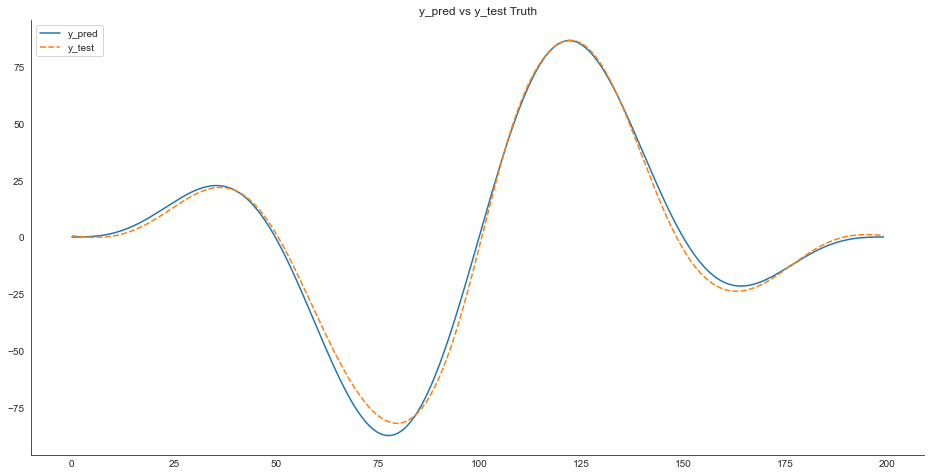

In [104]:
# Create the line plot
test_df = pd.DataFrame({'y_test': y_test_unscaled.flatten(), 'y_pred': y_pred.flatten()})
fig, ax1 = plt.subplots(figsize=(16, 8), sharex=True)
sns.lineplot(data=test_df)
ax1.tick_params(axis="x", rotation=0, labelsize=10, length=0)
plt.title("y_pred vs y_test Truth")
plt.legend(["y_pred", "y_test"], loc="upper left")

# Fill between plotlines
mpl.rc('hatch', color='k', linewidth=2)
ax1.fill_between(test_df.index, test_df["y_test"], test_df["y_pred"],  facecolor = 'white', alpha=.9) 
plt.show()

# Step #5 Calculating the Regression Error Metrics: Implementation and Evaluation

In [6]:
# Mean Absolute Error (MAE)
MAE = np.mean(abs(y_pred - y_test_unscaled))
print('Mean Absolute Error (MAE): ' + str(np.round(MAE, 2)))

# Median Absolute Error (MedAE)
MEDAE = np.median(abs(y_pred - y_test_unscaled))
print('Median Absolute Error (MedAE): ' + str(np.round(MEDAE, 2)))

# Mean Squared Error (MSE)
MSE = np.square(np.subtract(y_pred, y_test_unscaled)).mean()
print('Mean Squared Error (MSE): ' + str(np.round(MSE, 2)))

# Root Mean Squarred Error (RMSE) 
RMSE = np.sqrt(np.mean(np.square(y_pred - y_test_unscaled)))
print('Root Mean Squared Error (RMSE): ' + str(np.round(RMSE, 2)))

# Mean Absolute Percentage Error (MAPE)
MAPE = np.mean((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
print('Mean Absolute Percentage Error (MAPE): ' + str(np.round(MAPE, 2)) + ' %')

# Median Absolute Percentage Error (MDAPE)
MDAPE = np.median((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
print('Median Absolute Percentage Error (MDAPE): ' + str(np.round(MDAPE, 2)) + ' %')

Mean Absolute Error (MAE): 2.51
Median Absolute Error (MedAE): 1.65
Mean Squared Error (MSE): 11.4
Root Mean Squared Error (RMSE): 3.38
Mean Absolute Percentage Error (MAPE): 4735.19 %
Median Absolute Percentage Error (MDAPE): 11.28 %
